# Analysis of Chemicals in Cosmetic Products
# Forecasting
___

Some steps and codes of this notebook is based on the tutorial `Time Series Forecast Study with Python: Monthly Sales of French Champagne` (https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/)

## 1. Load data and Creation of Validation Dataset

#### Import libraries

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import os
import sys
import numpy    as np
import pandas   as pd
import datetime
import warnings

from matplotlib                   import pyplot
from dateutil.relativedelta       import relativedelta
from statsmodels.tsa.arima_model  import ARIMA
from sklearn.metrics              import mean_squared_error
from math                         import sqrt

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


#### Declare constants 

In [2]:
# Variables with the names of each column in data
CDPHID_COLUMN                 = 'CDPHId'
PRODUCTNAME_COLUMN            = 'ProductName'
CSFID_COLUMN                  = 'CSFId'
CSF_COLUMN                    = 'CSF'
COMPANYID_COLUMN              = 'CompanyId'
COMPANYNAME_COLUMN            = 'CompanyName'
BRANDNAME_COLUMN              = 'BrandName'
PRIMARYCATEGORYID_COLUMN      = 'PrimaryCategoryId'
PRIMARYCATEGORY_COLUMN        = 'PrimaryCategory'
SUBCATEGORYID_COLUMN          = 'SubCategoryId'
SUBCATEGORY_COLUMN            = 'SubCategory'
CASID_COLUMN                  = 'CasId'
CASNUMBER_COLUMN              = 'CasNumber'
CHEMICALID_COLUMN             = 'ChemicalId'
CHEMICALNAME_COLUMN           = 'ChemicalName'
INITIALDATEREPORTED_COLUMN    = 'InitialDateReported'
MOSTRECENTDATEREPORTED_COLUMN = 'MostRecentDateReported'
DISCONTINUEDDATE_COLUMN       = 'DiscontinuedDate'
CHEMICALCREATEDAT_COLUMN      = 'ChemicalCreatedAt'
CHEMICALUPDATEDAT_COLUMN      = 'ChemicalUpdatedAt'
CHEMICALDATEREMOVED_COLUMN    = 'ChemicalDateRemoved'
CHEMICALCOUNT_COLUMN          = 'ChemicalCount'

# Number to replace empty value in CSFId column
CSFID_EMPTY_NUMBER  = -1
# Date value which means NaT 
NAT_DATE            = datetime.date(1900,1,1)

# List of columns which contains a Names
list_names = [ PRODUCTNAME_COLUMN, CSF_COLUMN, COMPANYNAME_COLUMN, BRANDNAME_COLUMN, 
               PRIMARYCATEGORY_COLUMN, SUBCATEGORY_COLUMN, CHEMICALNAME_COLUMN ]

# List of columns which contains a Dates
list_dates = [ INITIALDATEREPORTED_COLUMN, MOSTRECENTDATEREPORTED_COLUMN, DISCONTINUEDDATE_COLUMN,
               CHEMICALCREATEDAT_COLUMN, CHEMICALUPDATEDAT_COLUMN, CHEMICALDATEREMOVED_COLUMN ]

# Other columns
list_ids   = [ CDPHID_COLUMN, CSFID_COLUMN, COMPANYID_COLUMN, PRIMARYCATEGORYID_COLUMN, 
               SUBCATEGORYID_COLUMN, CASID_COLUMN, CHEMICALID_COLUMN ]

# Path to save the images
IMAGES_PATH   = 'img'

# Format of images
IMAGES_FORMAT = '.png'

# Path where is the dataset
DATA_PATH = 'data'

# Path where is the backup dataset
DATA_BACKUP_PATH = 'data_backup'

# File name of dataset
DATA_NAME = 'cscpopendata.csv'

---

### 1.1. Load data

#### From data/ folder 

In [3]:
# Load data from data/ folder
data = pd.read_csv(os.path.join(DATA_PATH, DATA_NAME), sep = ',', parse_dates = list_dates)

# pd.isna() --> for NaN
# <value> is pd.NaT --> for NaT

# Fill NaT with 01/01/1900
for date_column in list_dates :
    data[date_column] = data[date_column].apply(lambda x: NAT_DATE if x is pd.NaT else x)
    

# Fill NA with ''
data = data.fillna('')

# Fill CSFId empty with -1
data[CSFID_COLUMN] = data[CSFID_COLUMN].apply(lambda x: x if x != "" else CSFID_EMPTY_NUMBER)

# Remove all rows that have a cosmetic product discontinued
data = data[data[DISCONTINUEDDATE_COLUMN].apply(lambda x: x.year) == NAT_DATE.year]

# Remove all rows that have a chemical removed
data = data[data[CHEMICALDATEREMOVED_COLUMN].apply(lambda x: x.year) == NAT_DATE.year]

# Group by InitialDateReported and sum ChemicalCount
data = pd.DataFrame(data.groupby(INITIALDATEREPORTED_COLUMN)
                    .agg({CHEMICALCOUNT_COLUMN : 'sum'}))

#### From data_backup/ folder 

In [4]:
# Load data from data_backup/ folder
data_backup = pd.read_csv(os.path.join(DATA_BACKUP_PATH, DATA_NAME), sep = ',', parse_dates = list_dates)

---

### 1.2. Creation of Validation Dataset

As the dataset is updated frequently, we are going to use it to create a validation dataset with the new data. We storage two data version: 

- The last data version in `data/` folder.
- The previous data version in `data_backup/` folder.

With that, we are going to split data as following:

- `dataset` variable will be the dataset with we are going to fit the model. This dataset will contain all data until the 5 previous months from the current month. Meaning, if the current month is 02/19 (Feb, 2019), this dataset will be contain all data until the month 09/18 (Sept, 2018): the last date in dataset will be 31/08/18 (Aug 31, 2018).
- `validation` variable will be the dataset with we are going to validate the model. This dataset will contain the rest of data.

Let's create both datasets:

In [5]:
# Get the max InitialDateReported from data
data_max = max(data.index)

# Get the max InitialDateReported from data_backup
data_backup_max = max(data_backup[INITIALDATEREPORTED_COLUMN])

print('data        | Max InitialDateReported = ', data_max)
print('data_backup | Max InitialDateReported = ', data_backup_max)

data        | Max InitialDateReported =  2019-02-21 00:00:00
data_backup | Max InitialDateReported =  2019-02-06 00:00:00


In [6]:
# Set the dataset_limit
dataset_limit = datetime.datetime(data_backup_max.year, data_backup_max.month, 1) - relativedelta(months=5)

print('Current month =', datetime.datetime(data_backup_max.year, data_backup_max.month, 1))
print('Dataset limit =', dataset_limit)

Current month = 2019-02-01 00:00:00
Dataset limit = 2018-09-01 00:00:00


In [7]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

Len(dataset) = 1749
Len(validation) = 114


Our current datetime data can be tricky to work with, therefore, we will use the averages daily chemical count for that month instead, and we are using the start of each month as the timestamp.

In [8]:
dataset.head()

,ChemicalCount
InitialDateReported,
2009-07-01,4
2009-07-09,1
2009-07-13,6
2009-07-14,18
2009-08-10,4


In [11]:
dataset = dataset.resample('MS').mean().dropna()
validation = validation.resample('MS').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))
dataset.head()

Len(dataset) = 110
Len(validation) = 6


,ChemicalCount
InitialDateReported,
2009-07-01,7.250000
2009-08-01,31.909091
2009-09-01,237.416667
2009-10-01,779.080000
2009-11-01,46.750000


---

## 2. Grid Search ARIMA Hyperparameters 

#### Functions definition 

In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [13]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # Make and fit model
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        # Prediction
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return model, rmse, train, test, predictions

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    _, mse, _, _, _ = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

---

#### Search hyperparameters 

We will search all combinations of the following parameters:

- p: 0 to 3.
- d: 0 to 2.
- q: 0 to 3.

This is (4 * 3 * 4), or 48, potential runs of the test harness.

In [14]:
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(dataset.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=49.449
ARIMA(0, 0, 2) RMSE=45.249
ARIMA(0, 0, 3) RMSE=43.409
ARIMA(0, 1, 1) RMSE=35.693
ARIMA(0, 1, 2) RMSE=35.416
ARIMA(0, 1, 3) RMSE=35.126
ARIMA(1, 0, 0) RMSE=44.414
ARIMA(1, 0, 1) RMSE=36.234
ARIMA(1, 0, 2) RMSE=35.947
ARIMA(1, 1, 0) RMSE=37.831
ARIMA(1, 1, 1) RMSE=34.894
ARIMA(1, 1, 2) RMSE=34.727
ARIMA(2, 0, 0) RMSE=41.369
ARIMA(2, 1, 0) RMSE=37.785
ARIMA(3, 0, 0) RMSE=41.133
ARIMA(3, 1, 0) RMSE=38.192
Best ARIMA(1, 1, 2) RMSE=34.727


We will select this ARIMA(3, 0, 0) model going forward.

---

## 3. Review Residual Errors

A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(1, 0, 0) model. Let's calculate and summarize the residual forecast errors:

In [15]:
best_cfg

(1, 1, 2)

                0
count   28.000000
mean    -0.681774
std     35.357139
min    -44.084437
25%    -23.597053
50%    -14.018207
75%     16.488001
max    106.028292


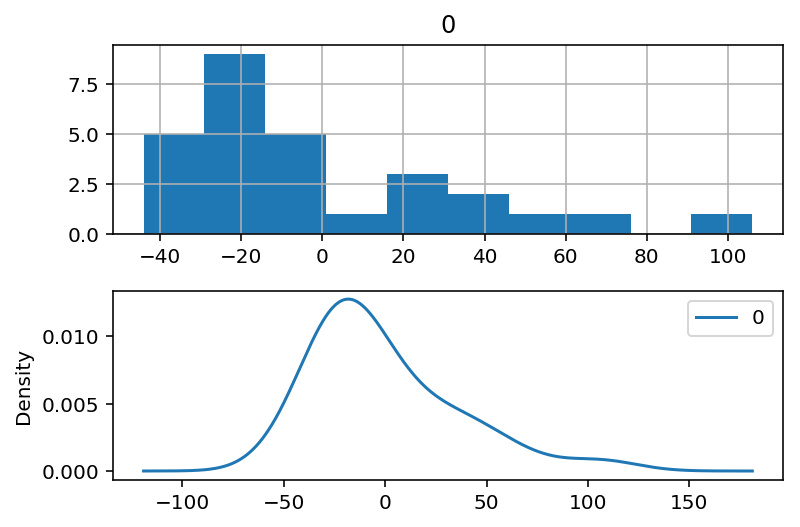

In [16]:
_, _, train, test, predictions = evaluate_arima_model(dataset.values, best_cfg)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero. So, the predictions are not biased.

---

## 4. Model Validation 

### 4.1. Finalize Model 

In [17]:
# prepare data
X = dataset.values
X = X.astype('float32')

# fit model
model = ARIMA(dataset.values, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

### 4.2. Make Prediction 

In [18]:
yhat = float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 66.896


In [19]:
validation[CHEMICALCOUNT_COLUMN][0]

91.3125

In [20]:
# prepare datasets
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
y = validation.values.astype('float32')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
#yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
    # difference data
    #months_in_year = 12
    #diff = difference(history, months_in_year)
    # predict
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    #yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    

>Predicted=66.896, Expected= 91
>Predicted=63.736, Expected= 24
>Predicted=46.744, Expected= 23
>Predicted=41.485, Expected= 45
>Predicted=45.358, Expected= 77
>Predicted=53.941, Expected= 72


RMSE: 26.126


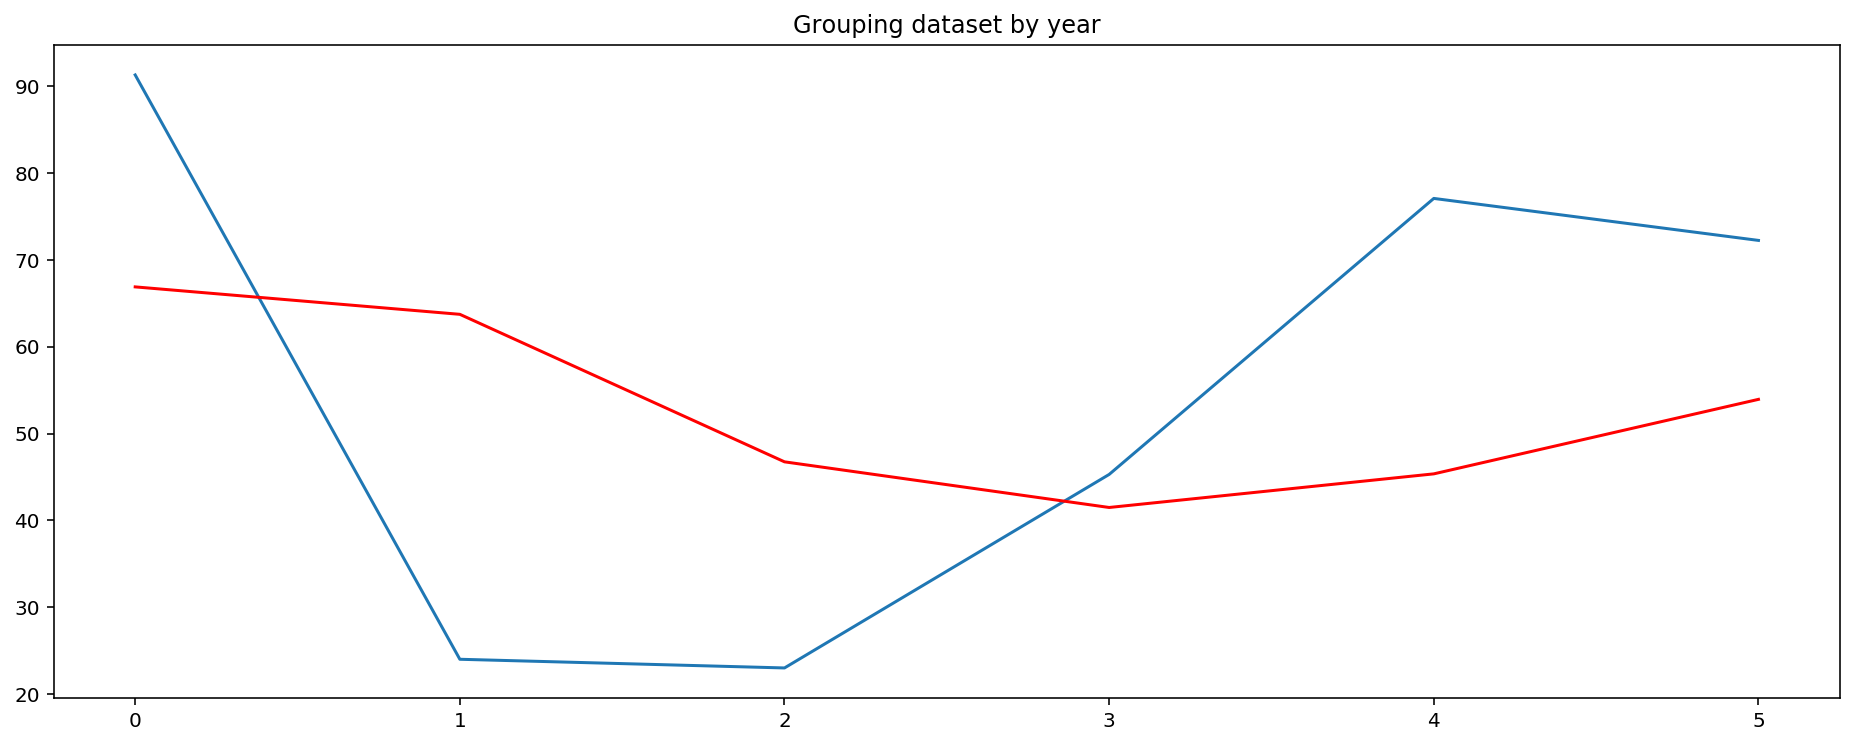

In [25]:
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.figure(figsize=(16, 6))
pyplot.title('Grouping dataset by year')
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

In [28]:
def all_process(dataset, validation, title) :
    # prepare data
    X = dataset.values
    X = X.astype('float32')
    y = validation.values.astype('float32')

    # evaluate parameters
    p_values = range(0, 4)
    d_values = range(0, 2)
    q_values = range(0, 4)
    warnings.filterwarnings("ignore")
    best_cfg = evaluate_models(dataset.values, p_values, d_values, q_values)

    model, rmse, train, test, predictions = evaluate_arima_model(dataset.values, best_cfg)

    # errors
    residuals = [test[i]-predictions[i] for i in range(len(test))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    # plot
    pyplot.figure()
    pyplot.subplot(211)
    residuals.hist(ax=pyplot.gca())
    pyplot.subplot(212)
    residuals.plot(kind='kde', ax=pyplot.gca())
    pyplot.show()

    # fit model
    model_fit = model.fit(trend='nc', disp=0)

    history = [x for x in X]
    # make first prediction
    predictions = list()
    yhat = float(model_fit.forecast()[0])
    predictions.append(yhat)
    history.append(y[0])
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

    # rolling forecasts
    for i in range(1, len(y)):
        # predict
        model = ARIMA(history, order=best_cfg)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # observation
        obs = y[i]
        history.append(obs)
        print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

    # report performance
    mse = mean_squared_error(y, predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)
    pyplot.figure(figsize=(16, 6))
    pyplot.title(title)
    pyplot.plot(y)
    pyplot.plot(predictions, color='red')
    pyplot.show()

Len(dataset) = 1749
Len(validation) = 114
Len(dataset) = 223
Len(validation) = 12
ARIMA(0, 0, 1) RMSE=51.748
ARIMA(0, 0, 2) RMSE=49.349
ARIMA(0, 0, 3) RMSE=48.667
ARIMA(0, 1, 1) RMSE=42.028
ARIMA(0, 1, 2) RMSE=40.229
ARIMA(1, 0, 0) RMSE=45.969
ARIMA(1, 0, 1) RMSE=43.645
ARIMA(1, 0, 2) RMSE=40.520
ARIMA(1, 1, 0) RMSE=43.870
ARIMA(1, 1, 1) RMSE=40.006
ARIMA(1, 1, 2) RMSE=40.025
ARIMA(1, 1, 3) RMSE=41.194
ARIMA(2, 0, 0) RMSE=44.717
ARIMA(2, 0, 1) RMSE=40.293
ARIMA(2, 1, 0) RMSE=41.319
ARIMA(2, 1, 1) RMSE=40.039
ARIMA(2, 1, 3) RMSE=41.625
ARIMA(3, 0, 0) RMSE=44.397
ARIMA(3, 1, 0) RMSE=41.988
ARIMA(3, 1, 1) RMSE=41.500
ARIMA(3, 1, 2) RMSE=41.482
ARIMA(3, 1, 3) RMSE=40.305
Best ARIMA(1, 1, 1) RMSE=40.006
                0
count   56.000000
mean     6.174680
std     39.884326
min    -57.981841
25%    -16.909015
50%     -9.096150
75%     25.216979
max    144.172245


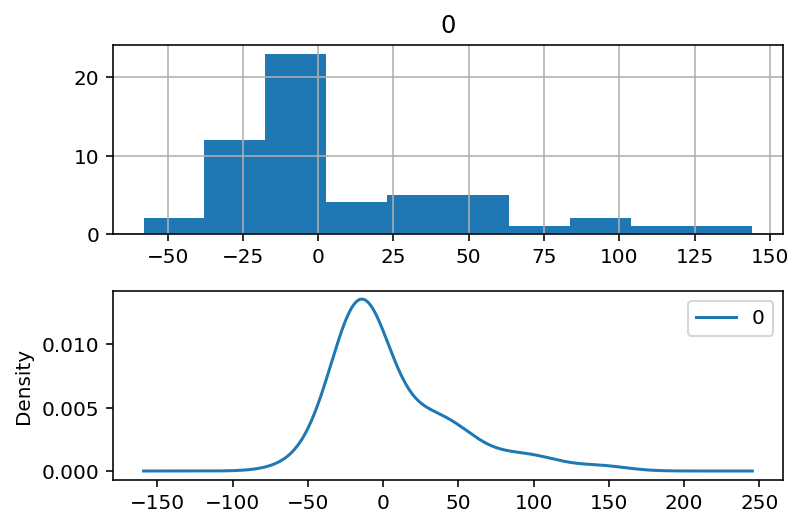

>Predicted=68.767, Expected= 36
>Predicted=48.564, Expected=134
>Predicted=84.197, Expected= 22
>Predicted=45.482, Expected= 20
>Predicted=43.535, Expected= 30
>Predicted=45.721, Expected= 32
>Predicted=45.610, Expected= 30
>Predicted=44.514, Expected= 48
>Predicted=50.318, Expected= 50
>Predicted=50.730, Expected=117
>Predicted=75.479, Expected= 85
>Predicted=65.613, Expected= 10
RMSE: 41.960


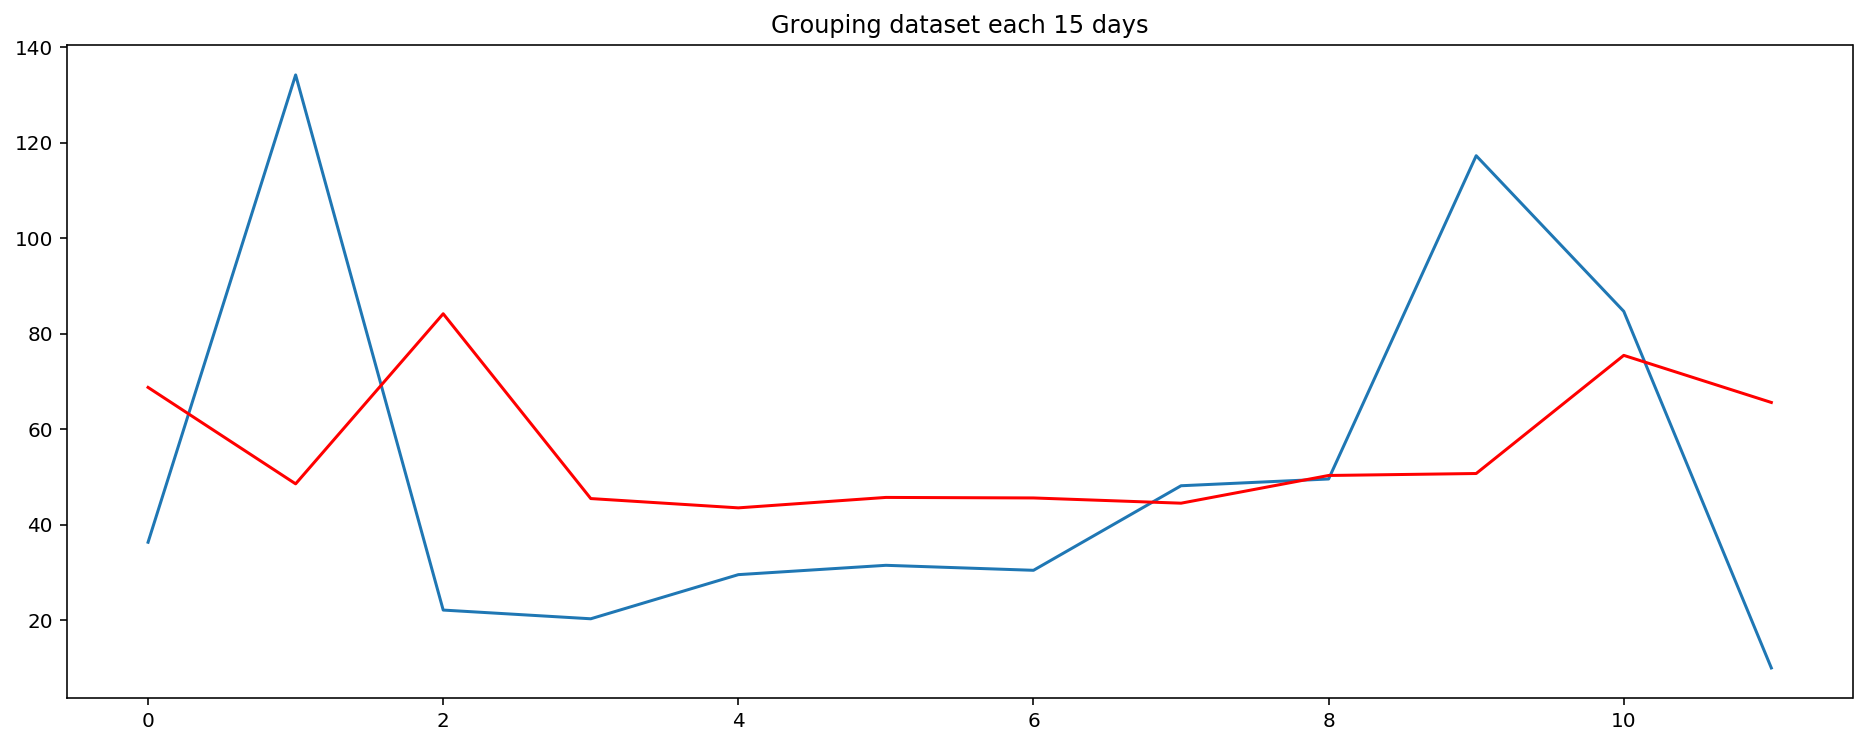

In [29]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

dataset = dataset.resample('15D').mean().dropna()
validation = validation.resample('15D').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))
dataset.head()

all_process(dataset, validation, 'Grouping dataset each 15 days')

Len(dataset) = 1749
Len(validation) = 114
Len(dataset) = 467
Len(validation) = 25
ARIMA(0, 0, 1) RMSE=94.623
ARIMA(0, 0, 2) RMSE=92.431
ARIMA(0, 1, 1) RMSE=83.106
ARIMA(0, 1, 2) RMSE=86.707
ARIMA(0, 1, 3) RMSE=86.466
ARIMA(1, 0, 0) RMSE=84.826
ARIMA(1, 0, 1) RMSE=88.194
ARIMA(1, 0, 2) RMSE=87.447
ARIMA(1, 0, 3) RMSE=86.513
ARIMA(1, 1, 0) RMSE=91.595
ARIMA(1, 1, 2) RMSE=86.054
ARIMA(2, 0, 0) RMSE=86.445
ARIMA(2, 0, 1) RMSE=86.027
ARIMA(2, 0, 2) RMSE=86.084
ARIMA(2, 1, 0) RMSE=94.130
ARIMA(2, 1, 2) RMSE=86.064
ARIMA(3, 0, 0) RMSE=88.730
ARIMA(3, 0, 1) RMSE=87.480
ARIMA(3, 0, 3) RMSE=86.287
ARIMA(3, 1, 0) RMSE=90.977
ARIMA(3, 1, 2) RMSE=86.034
Best ARIMA(0, 1, 1) RMSE=83.106
                0
count  117.000000
mean     0.482262
std     83.462130
min   -359.359210
25%    -20.516331
50%     -2.660982
75%     15.211980
max    511.880768


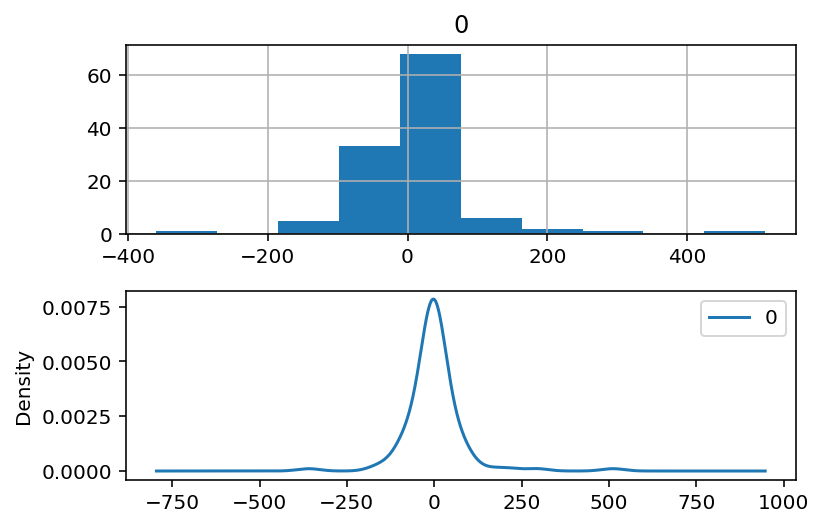

>Predicted=60.363, Expected= 34
>Predicted=60.844, Expected= 45
>Predicted=52.417, Expected=274
>Predicted=169.131, Expected= 21
>Predicted=91.816, Expected= 28
>Predicted=59.042, Expected= 16
>Predicted=36.974, Expected= 32
>Predicted=34.610, Expected=  6
>Predicted=19.584, Expected= 20
>Predicted=19.592, Expected= 24
>Predicted=21.995, Expected= 38
>Predicted=30.505, Expected= 20
>Predicted=24.831, Expected= 43
>Predicted=34.196, Expected= 33
>Predicted=33.580, Expected= 22
>Predicted=27.818, Expected= 47
>Predicted=37.806, Expected= 56
>Predicted=47.271, Expected= 65
>Predicted=56.416, Expected= 32
>Predicted=43.932, Expected= 44
>Predicted=43.864, Expected=208
>Predicted=128.382, Expected= 60
>Predicted=93.316, Expected=125
>Predicted=109.468, Expected= 30
>Predicted=69.215, Expected= 10
RMSE: 70.320


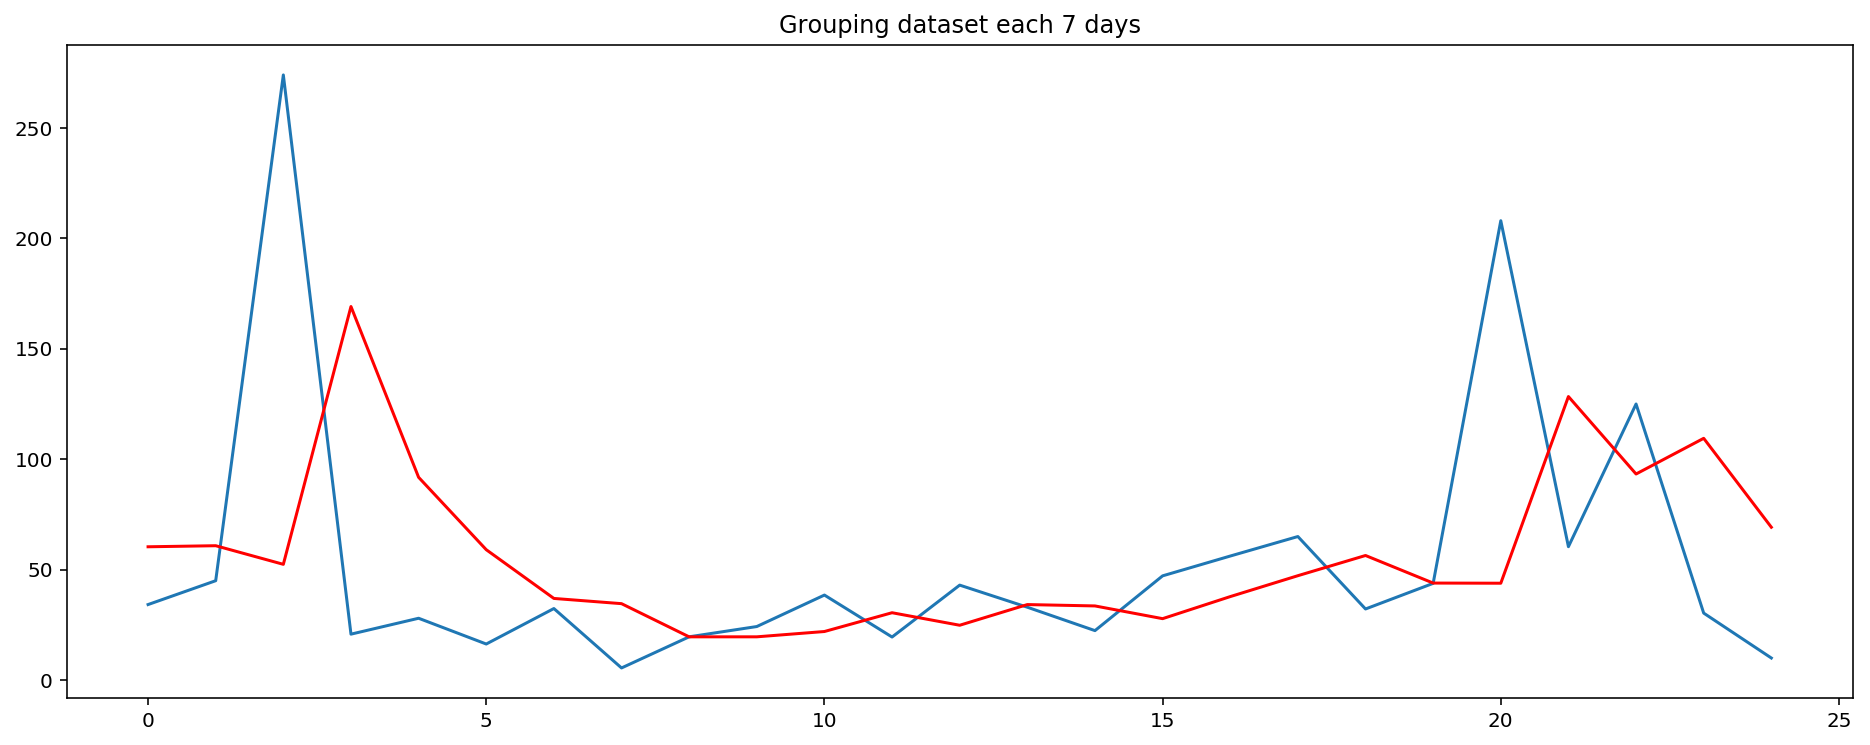

In [30]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

dataset = dataset.resample('7D').mean().dropna()
validation = validation.resample('7D').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))
dataset.head()

all_process(dataset, validation, 'Grouping dataset each 7 days')

Len(dataset) = 1749
Len(validation) = 114
ARIMA(0, 0, 1) RMSE=123.737
ARIMA(0, 0, 2) RMSE=125.645
ARIMA(0, 1, 1) RMSE=126.733
ARIMA(0, 1, 2) RMSE=119.169
ARIMA(0, 1, 3) RMSE=121.131
ARIMA(1, 0, 0) RMSE=120.300
ARIMA(1, 0, 1) RMSE=123.332
ARIMA(1, 0, 2) RMSE=118.497
ARIMA(1, 0, 3) RMSE=120.531
ARIMA(1, 1, 0) RMSE=131.818
ARIMA(1, 1, 1) RMSE=116.932
ARIMA(1, 1, 2) RMSE=120.863
ARIMA(1, 1, 3) RMSE=121.477
ARIMA(2, 0, 0) RMSE=122.883
ARIMA(2, 0, 1) RMSE=116.393
ARIMA(2, 0, 2) RMSE=119.823
ARIMA(2, 0, 3) RMSE=121.250
ARIMA(2, 1, 0) RMSE=132.442
ARIMA(2, 1, 1) RMSE=122.347
ARIMA(2, 1, 2) RMSE=124.040
ARIMA(2, 1, 3) RMSE=121.644
ARIMA(3, 0, 0) RMSE=123.960
ARIMA(3, 0, 1) RMSE=121.902
ARIMA(3, 0, 2) RMSE=120.853
ARIMA(3, 0, 3) RMSE=119.811
ARIMA(3, 1, 0) RMSE=128.357
ARIMA(3, 1, 1) RMSE=121.844
ARIMA(3, 1, 2) RMSE=122.037
ARIMA(3, 1, 3) RMSE=123.298
Best ARIMA(2, 0, 1) RMSE=116.393
                 0
count   438.000000
mean      8.137854
std     116.240636
min    -733.700684
25%     -15.831438

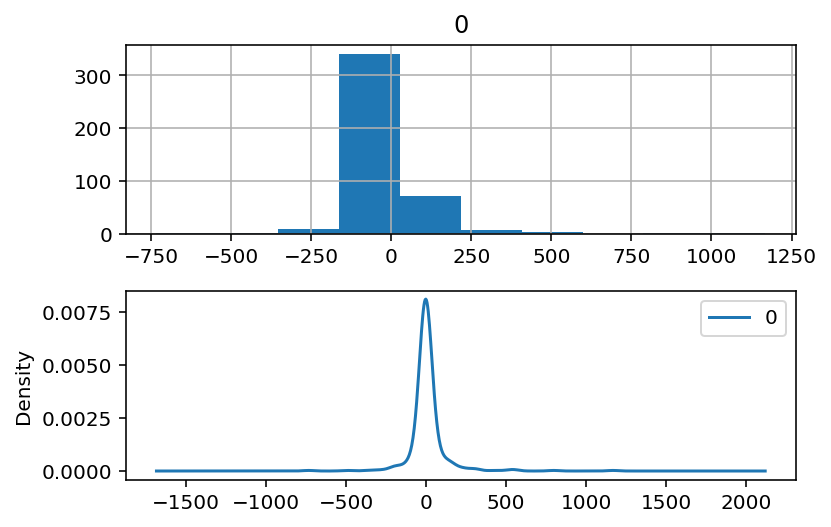

>Predicted=130.459, Expected= 16
>Predicted=34.488, Expected=  1
>Predicted=23.012, Expected= 10
>Predicted=25.957, Expected=118
>Predicted=89.591, Expected= 26
>Predicted=35.031, Expected= 50
>Predicted=48.156, Expected= 71
>Predicted=60.310, Expected= 14
>Predicted=25.768, Expected= 21
>Predicted=28.451, Expected=105
>Predicted=78.263, Expected=969
>Predicted=606.207, Expected=  1
>Predicted=44.730, Expected=  7
>Predicted=43.093, Expected=  2
>Predicted=35.762, Expected=  1
>Predicted=31.190, Expected= 49
>Predicted=56.169, Expected= 45
>Predicted=52.135, Expected= 29
>Predicted=41.046, Expected= 28
>Predicted=38.562, Expected= 54
>Predicted=52.300, Expected=  1
>Predicted=20.114, Expected=  5
>Predicted=20.242, Expected= 14
>Predicted=23.724, Expected= 30
>Predicted=31.854, Expected= 16
>Predicted=22.815, Expected= 29
>Predicted=29.469, Expected= 11
>Predicted=18.234, Expected=  2
>Predicted=11.860, Expected=104
>Predicted=71.234, Expected=  3
>Predicted=13.334, Expected=  4
>Predi

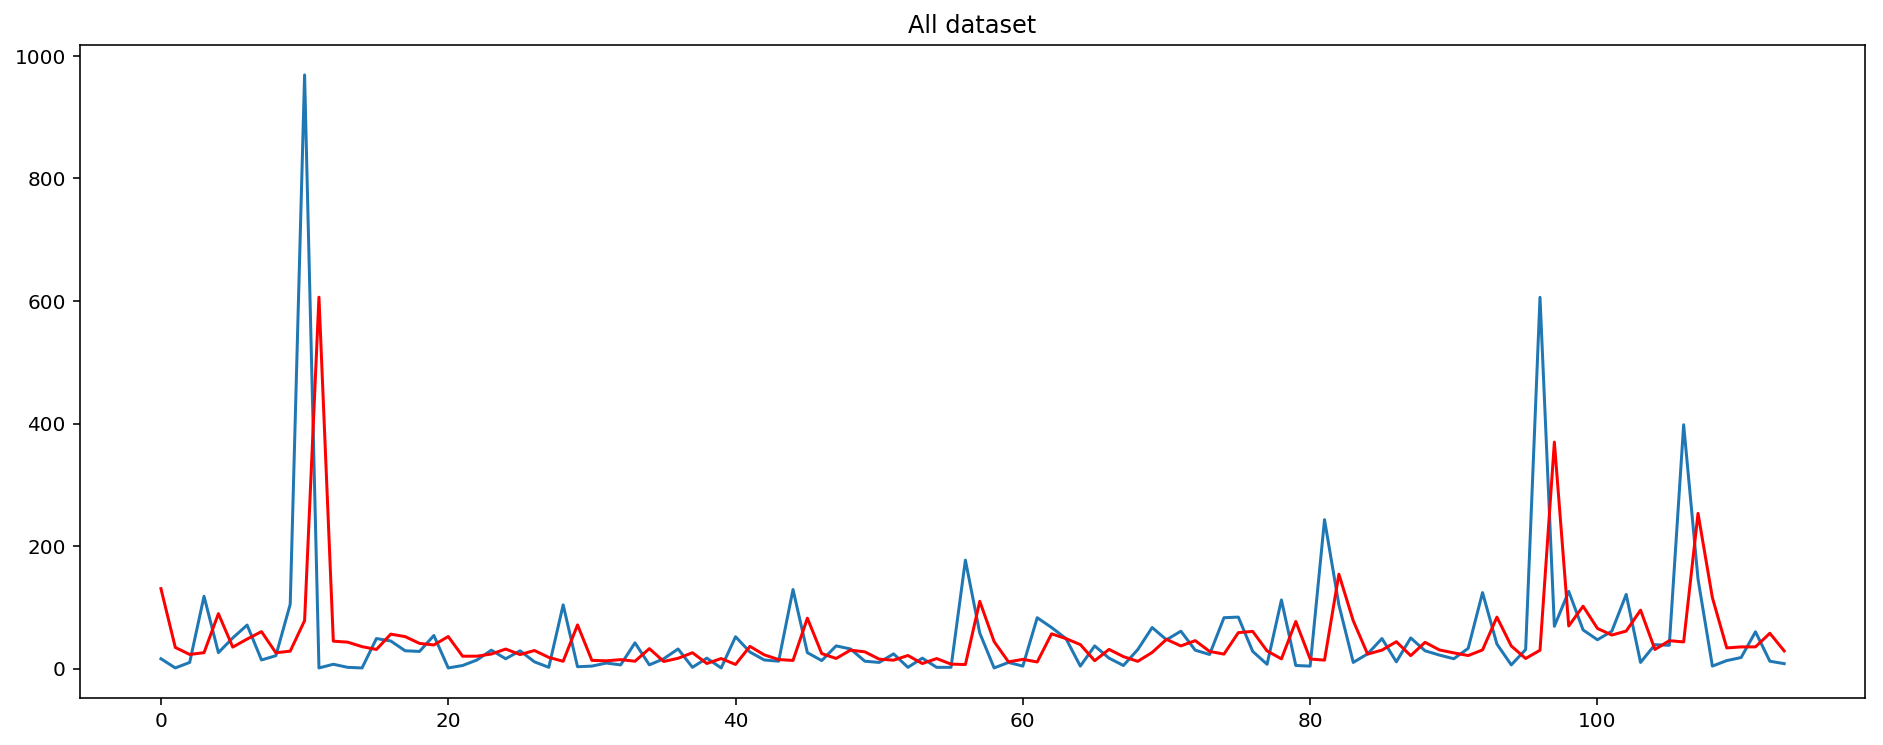

In [31]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

all_process(dataset, validation, 'All dataset')